In [2]:
pip install dynamask

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 KB 10.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 KB 29.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 88.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.5 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283857 sha256=d290dbd11bbe5629430e4251498d1a3521f7a2c82869f2517f5a57ef94aaa52e
  Stored in directory: /root/.cache/pip/wheels/e6/a6/20/cc1e293fcdb67ede666fed293cb895395e7ecceb4467779546
Successfully built lime


In [1]:
import numpy as np
import pandas as pd
import argparse
import os
import pickle as pkl
from dynamask.fit.TSX.utils import load_data
import torch
import torch.utils.data as utils
from torch.utils.data import DataLoader
from dynamask.attribution.perturbation import FadeMovingAverage
from  dynamask.attribution.perturbation import GaussianBlur
from torch.nn.functional import mse_loss
from dynamask.attribution.mask import Mask
from dynamask.models.models import StateClassifier
#from dynamask.utils.losses import log_loss_target
from sklearn.linear_model import LinearRegression, Ridge, Lasso

In [4]:
data1=pd.read_csv("/content/day.csv")

- instant: record index
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :- 1: Clear, Few clouds, Partly cloudy, Partly cloudy- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: Count 


In [5]:
data1


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


In [6]:

data=data1.dropna()
from sklearn.model_selection import train_test_split
X= data.drop(['cnt'],axis=1)
y=data[['dteday','cnt']]
  
X.reset_index(drop = True, inplace = True)
X.set_index('dteday', inplace = True)

y.reset_index(drop = True, inplace = True)
y.set_index('dteday', inplace = True)
X_train, X_test,y_train, y_test = train_test_split(X,y ,
                                   random_state=104, 
                                   test_size=0.20, 
                                   shuffle=False)
     

In [8]:
model = Lasso(0.25)
model.fit(X_train,y_train)
def lasso_output(x):
    out=model.predict(x.detach().cpu().numpy())
    return torch.tensor(out)



In [9]:
X_test

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered
dteday,,,,,,,,,,,,,,
2012-08-07,585,3,1,8,0,2,1,2,0.735833,0.697621,0.703750,0.116908,1278,5995
2012-08-08,586,3,1,8,0,3,1,2,0.750000,0.707717,0.672917,0.110700,1263,6271
2012-08-09,587,3,1,8,0,4,1,1,0.755833,0.699508,0.620417,0.156100,1196,6090
2012-08-10,588,3,1,8,0,5,1,2,0.715833,0.667942,0.715833,0.238813,1065,4721
2012-08-11,589,3,1,8,0,6,0,2,0.692500,0.638267,0.732917,0.206479,2247,4052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-27,727,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867
2012-12-28,728,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451
2012-12-29,729,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182


In [11]:
from sklearn.metrics import r2_score
yp2=model.predict(X_test)
print(r2_score(y_test,yp2))

0.9999999999343957


In [23]:
y_test

,cnt
dteday,
2012-08-07,7273
2012-08-08,7534
2012-08-09,7286
2012-08-10,5786
2012-08-11,6299
...,...
2012-12-27,2114
2012-12-28,3095
2012-12-29,1341


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


Our demo Mask Training

In [13]:
from dynamask.attribution.mask_group import MaskGroup

In [28]:
#Fit a group of masks to the input with a Gaussian Blur perturbation:
pert = GaussianBlur(device)
mask = MaskGroup(pert, device)
# Fit a group of masks to the input with a Gaussian Blur perturbation:

areas = [0.1, .25,0.35,0.45,0.55,0.65,0.66,0.665,0.678,.663,0.64]
mask.fit(torch.tensor(X_test.values, dtype=torch.float), f=lasso_output, loss_function=mse_loss,area_list=areas, size_reg_factor_init=0.01,learning_rate=2.5, size_reg_factor_dilation=10000, initial_mask_coeff=0.5, n_epoch=1000, momentum=1.0, time_reg_factor=2)


Epoch 1/1000: error = 3.59e+05 ; size regulator = 0.25 ; time regulator = 0 ; time elapsed = 0.245 s
Epoch 2/1000: error = 3.59e+05 ; size regulator = 0.25 ; time regulator = 8.54e-08 ; time elapsed = 0.492 s
Epoch 3/1000: error = 3.59e+05 ; size regulator = 0.25 ; time regulator = 3.1e-05 ; time elapsed = 0.2 s
Epoch 4/1000: error = 3.59e+05 ; size regulator = 0.25 ; time regulator = 3.06e-05 ; time elapsed = 0.125 s
Epoch 5/1000: error = 3.59e+05 ; size regulator = 0.25 ; time regulator = 4.79e-05 ; time elapsed = 0.129 s
Epoch 6/1000: error = 3.59e+05 ; size regulator = 0.25 ; time regulator = 4.61e-05 ; time elapsed = 0.126 s
Epoch 7/1000: error = 3.59e+05 ; size regulator = 0.25 ; time regulator = 7.42e-05 ; time elapsed = 0.135 s
Epoch 8/1000: error = 3.59e+05 ; size regulator = 0.25 ; time regulator = 7.71e-05 ; time elapsed = 0.126 s
Epoch 9/1000: error = 3.59e+05 ; size regulator = 0.25 ; time regulator = 8.87e-05 ; time elapsed = 0.128 s
Epoch 10/1000: error = 3.59e+05 ; size

The mask of area 0.66 is the best with error = 1.35e+05.


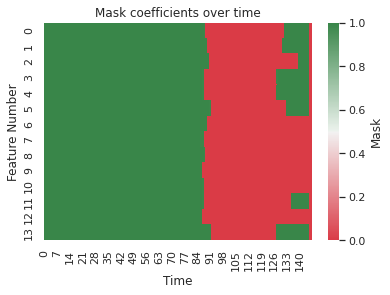

In [29]:
masks = mask.get_extremal_mask(threshold=0.3)
masks.plot_mask(smooth= False, sigma=2.0)